In [7]:
import os
import sys
# add /home/shiftpub/Dynamic_AMM as a path
sys.path.append(os.path.join(os.getcwd(), '..'))
import matplotlib.pyplot as plt
import numpy as np
import os
import imageio

def step(trader, u=1):
    trader.oracle.pr *= u
    trader.swap()
    return trader.oracle.get_price()

def get_u2_range(u1, alpha, f):
    overlap = False if u1 > (1-f)**(-2*alpha-2) else True # threshold for overlap
    u2_lower = 1/(u1*(1-f)**(2*alpha-2))
    if not overlap:
        u2_upper = 1/(u1*(1-f)**(2*alpha))
    else:
        u2_upper = 1/(np.sqrt(u1)*(1-f)**(alpha-1))
    return u2_lower, u2_upper
        
def plot_results(trader, config):
    results = []
    results.append(step(trader, 1))
    results.append(step(trader, 1))
    results.append(step(trader, config['u1']))
    # Determine common y-axis limits
    ylim_lower = config['ylim_lower']
    ylim_upper = config['ylim_upper']
    IGs = {
        'p2': [],
        'IG': []
    }
    for p2 in np.linspace(ylim_lower, ylim_upper, 100):
        trader.reset()
        u2 = p2/(config['p0']*config['u1'])
        step(trader, config['u1'])
        step(trader, u2)
        vh = trader.amm.initial_lr * trader.oracle.pr + trader.amm.initial_ls * trader.oracle.ps
        vs = trader.amm.lr * trader.oracle.pr + trader.amm.ls * trader.oracle.ps
        IGs['p2'].append(p2)
        IGs['IG'].append((vs - vh))
    amm_asks = [x[0] for x in results]
    amm_bids = [x[1] for x in results]
    mkt_mids = [x[2]+config['delta'] for x in results]
    if config['u1'] > (1-config['f'])**(-2*config['alpha']-2): # threshold for overlap
        title = f"Without Overlap | Alpha : {config['alpha']} | u1 : {config['u1']:.4f}" 
    else:
        title = f"With Overlap | Alpha : {config['alpha']} | u1 : {config['u1']:.4f}"
    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 0.6]})

    # Left subplot with shaded area for valid p2 range
    amm_bids.append(None)
    amm_asks.append(None)
    mkt_mids.append(None)
    axes[0].step(range(4), amm_bids[:4], label='amm_bid', linestyle='--', where='pre')
    axes[0].step(range(4), amm_asks[:4], label='amm_ask', linestyle='--', where='pre')
    axes[0].step(range(4), mkt_mids[:4], label='mkt_mid', linestyle='-', where='pre')

    # Shade the area for valid p2 range
    p2_lower = config['p0'] * config['u1'] * config['u2_lower']
    p2_upper = config['p0'] * config['u1'] * config['u2_upper']
    axes[0].fill_between([2, 3], p2_lower, p2_upper, color='gray', alpha=0.3, label='Possible p2 Range')
    axes[0].hlines(p2_lower, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
    axes[0].hlines(p2_upper, 2, 3, colors='black', linestyles='dashed', linewidth=1.5)
    axes[0].grid(axis='y', linestyle='--', alpha=0.6)
    axes[0].set_xticks([0, 1, 2])
    axes[0].set_xticklabels(["t0", "t1", "t2"], fontsize=12, fontweight='bold')
    axes[0].legend(fontsize=12)
    axes[0].set_title(title, fontsize=14, fontweight='bold')
    axes[0].set_ylim(ylim_lower, ylim_upper)  # Set y-axis limits for alignment

    # Right subplot: bar chart of impermanent gains for each p2
    axes[1].plot(IGs['IG'], IGs['p2'])
    axes[1].set_xlabel("Impermanent Gain", fontsize=12, fontweight='bold')
    axes[1].set_ylabel("p2", fontsize=12, fontweight='bold')
    axes[1].set_title("Impermanent Gain for p2 Range", fontsize=14, fontweight='bold')
    axes[1].axvline(x=0, color='black', linestyle='--', alpha=0.6)
    axes[1].axhline(y=p2_lower, color='black', linestyle='--', alpha=0.6)
    axes[1].axhline(y=p2_upper, color='black', linestyle='--', alpha=0.6)
    axes[1].grid(axis='y', linestyle='--', alpha=0.6)
    axes[1].set_ylim(ylim_lower, ylim_upper)  # Set the same y-axis limits for alignment
    # axes[1].set_xscale('log')
    
    plt.tight_layout()
    # plt.savefig(f"{config['path']}/{config['photo_idx']}.png")
    # plt.close()
    plt.show()

def make_gif(path):
    # Path to the directory containing images
    image_dir = path

    # Output GIF path
    output_gif = os.path.join(image_dir, "output.gif")

    # Get a sorted list of image file names
    images = sorted(
        [img for img in os.listdir(image_dir) if img.endswith(".png")],
        key=lambda x: int(x.split('.')[0])  # Sort by numerical order
    )

    # Read and collect the images
    frames = []
    for image in images:
        img_path = os.path.join(image_dir, image)
        frames.append(imageio.imread(img_path))

    # Save the GIF
    imageio.mimsave(output_gif, frames, duration=1)  # Adjust duration as needed (in seconds)

    # # Delete all PNG files
    # for image in images:
    #     img_path = os.path.join(image_dir, image)
    #     os.remove(img_path)

    print(f"GIF created at {output_gif}")
    print("All PNG files deleted.")


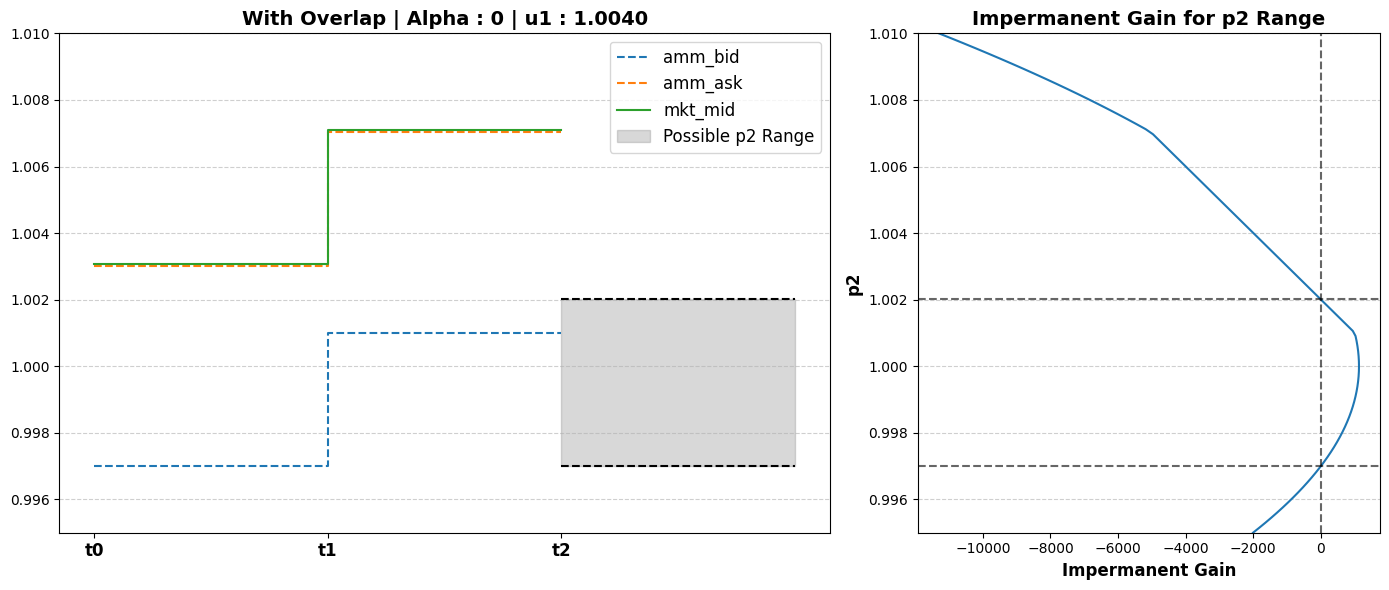

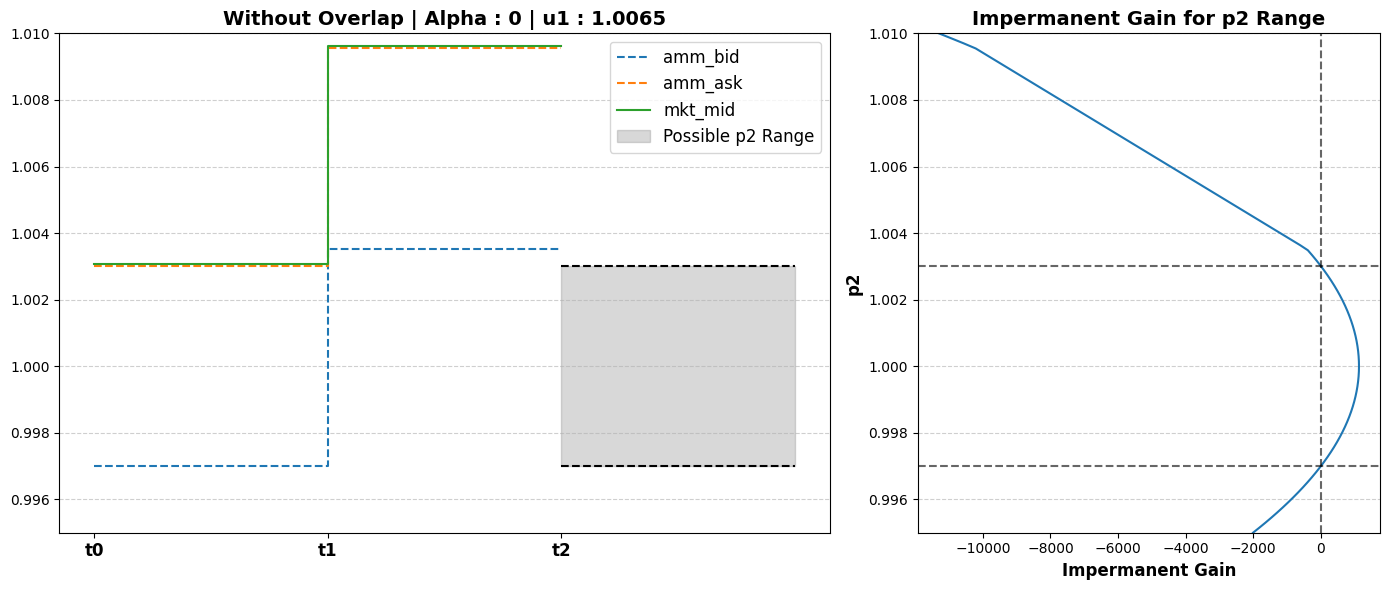

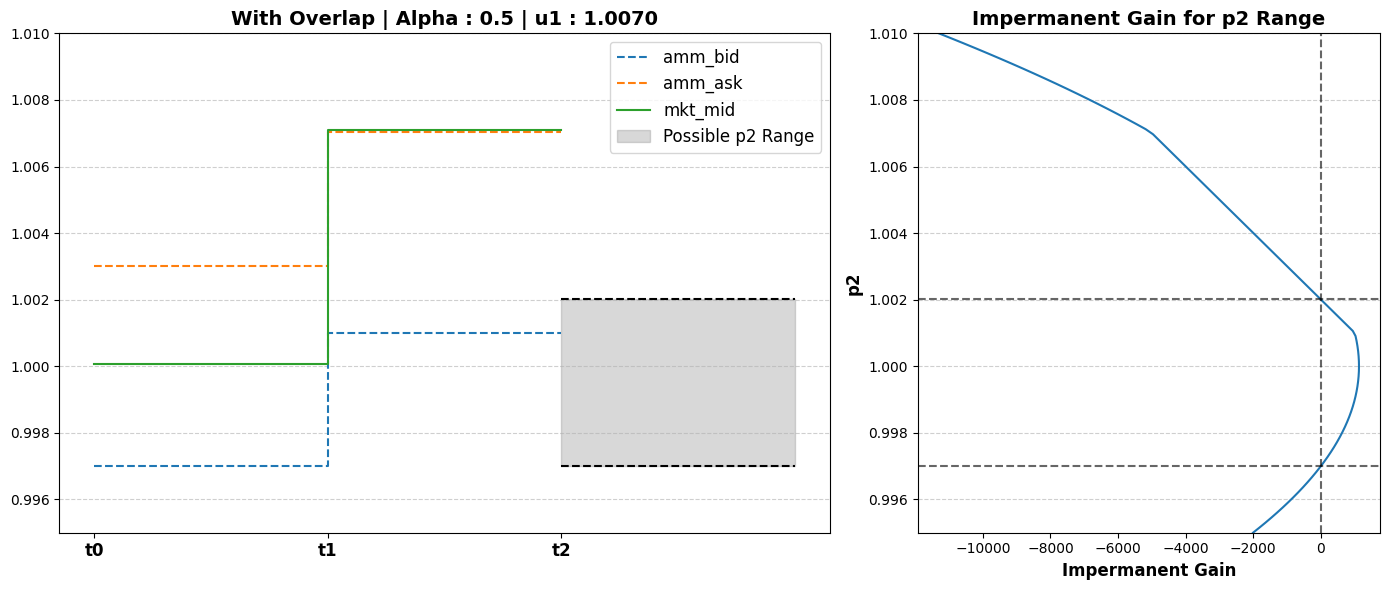

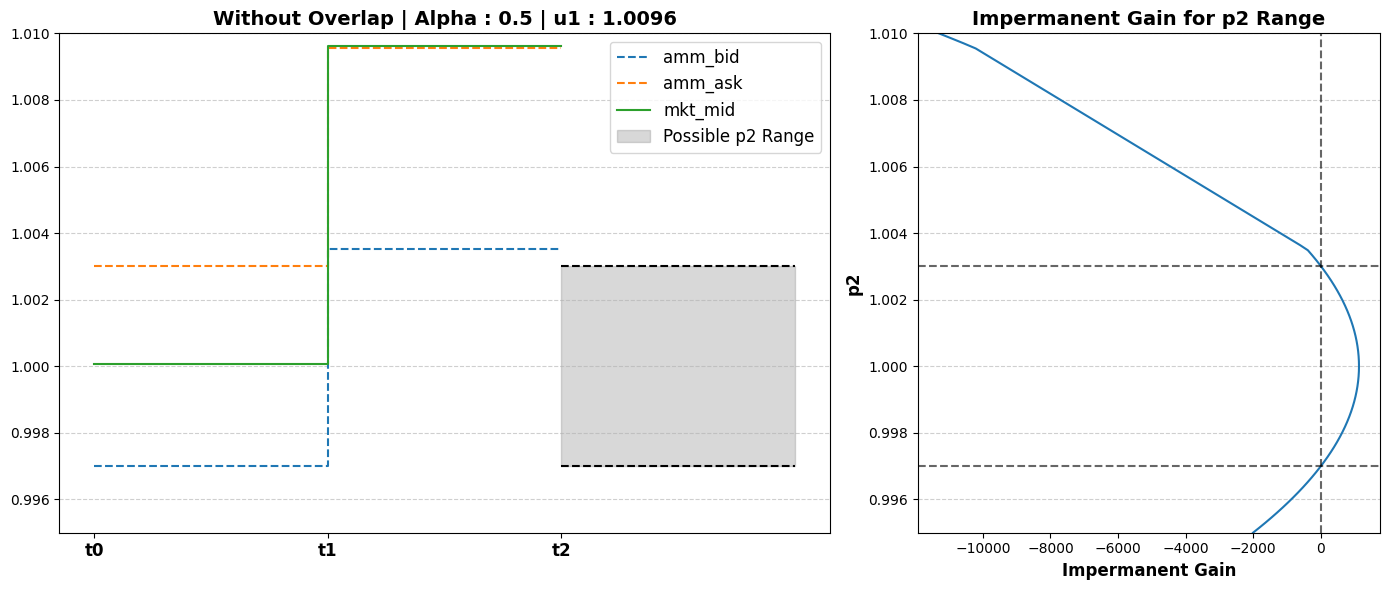

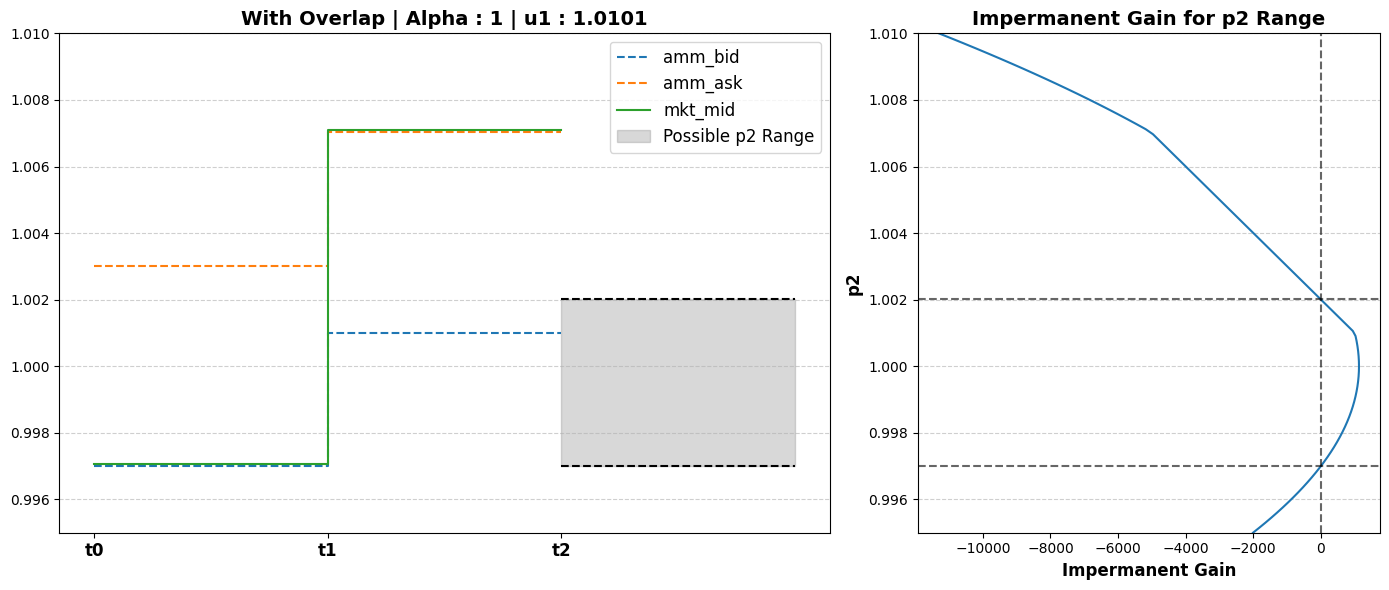

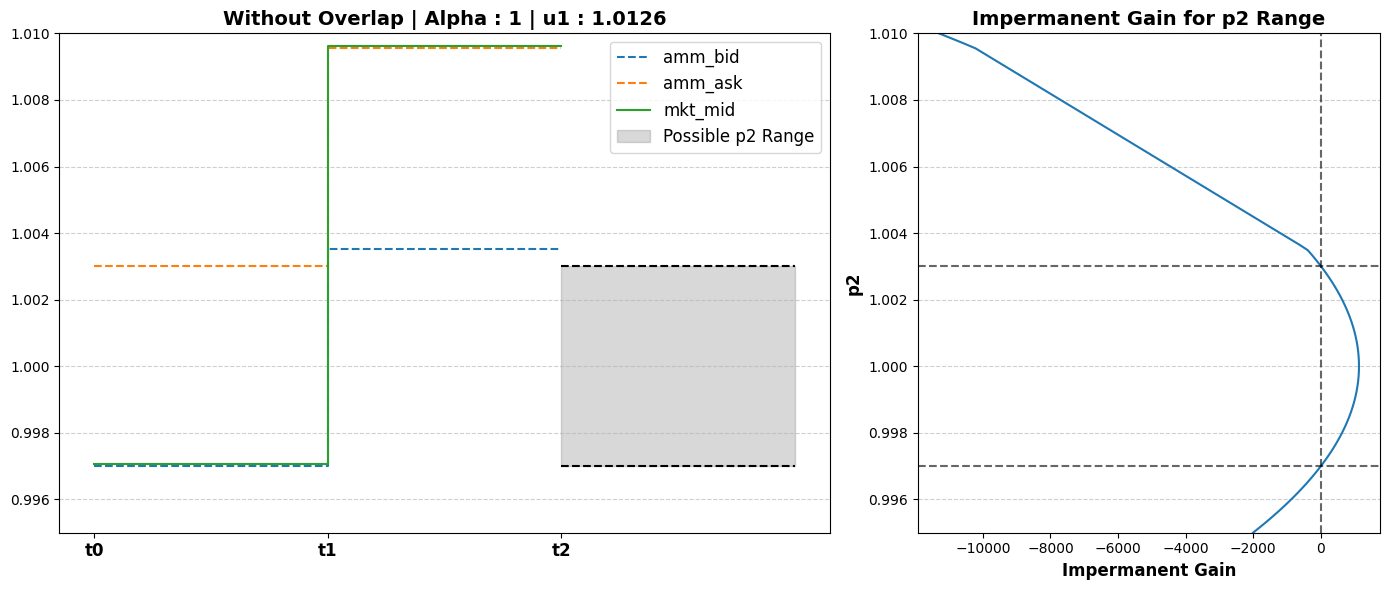

In [10]:
from env.oracle import OracleSimulator
from env.trader import Arbitrager
import numpy as np

path = '/home/shiftpub/Dynamic_AMM/env/plots_for_alpha'
photo_idx = 0
alphas = [0, 0.5, 1]

for alpha in alphas:
    oracle = OracleSimulator(alpha=alpha)
    trader = Arbitrager(oracle)
    threshold = (1-oracle.amm.f)**(-2*alpha-2)
    # u1_delta = np.linspace(1/threshold, 1.0005, 1000)[1::10]
    u1_delta = [0.998, 1.0005]
    for s in u1_delta:
        trader.reset()
        delta = 6e-5
        u1 =  threshold * s
        u2_lower, u2_upper = get_u2_range(u1, alpha, oracle.amm.f)
        p0 = oracle.get_price()[2]
        ylim_upper = 1.01
        ylim_lower = 0.995
        config = {
            'p0': p0,
            'u1': u1,
            'u2_upper': u2_upper,
            'u2_lower': u2_lower,
            'delta': delta,
            'ylim_upper': ylim_upper,
            'ylim_lower': ylim_lower,
            'f': oracle.amm.f,
            'alpha': alpha,
            'path': path,
            'photo_idx': photo_idx
        }

        plot_results(trader, config)
        photo_idx += 1

# make_gif(path)